In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [39]:
train_dset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

num_labels = train_dset.targets.unique().size(0)
num_labels

10

In [5]:
from torch.utils.data import random_split
train_size = int(0.8 * len(train_dset))
val_size = len(train_dset) - train_size

train_dset, val_dset = random_split(train_dset, [train_size, val_size])

print(f"Train size: {len(train_dset)}")
print(f"Validation size: {len(val_dset)}")
print(f"Test size: {len(test_dset)}")

Train size: 38400
Validation size: 9600
Test size: 10000


Label: 3


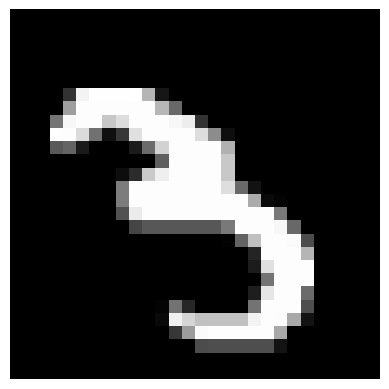

In [6]:
import matplotlib.pyplot as plt

def show_image(image, label):
    print('Label:', label)
    plt.imshow(image[0], cmap='gray')
    plt.axis('off')
    plt.show()
    
show_image(*train_dset[0])

In [7]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dset, batch_size=batch_size, shuffle=False)

In [48]:
class MNISTCNNModel(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 num_classes: int,
                 conv1_out: int = 8,
                 conv2_out: int = 16,
                 ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv1_out, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(conv1_out)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=conv1_out, out_channels=conv2_out, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm2d(conv2_out)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.linear1 = nn.Linear(conv2_out*7*7, hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.2)
        self.linear4 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batchnorm(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.linear2(x)
        
        return x
    
model = MNISTCNNModel(16, 10).to(device=device)
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0591, -0.0345, -0.1356,  0.1837, -0.1624],
                        [ 0.0553,  0.0546, -0.0201, -0.1336, -0.0056],
                        [-0.1818, -0.1596,  0.0733,  0.0797, -0.0849],
                        [ 0.1055,  0.1097, -0.0936, -0.1156, -0.1432],
                        [ 0.0225, -0.1395,  0.1290,  0.1734, -0.1110]]],
              
              
                      [[[-0.0064, -0.0594,  0.1188, -0.1910, -0.0815],
                        [-0.0449,  0.1321,  0.0663,  0.0215,  0.1086],
                        [ 0.1970, -0.0257,  0.1870, -0.0086,  0.0297],
                        [ 0.0521,  0.0145, -0.0288, -0.1928,  0.1354],
                        [ 0.0887,  0.0011,  0.1941, -0.1994,  0.0261]]],
              
              
                      [[[ 0.0708,  0.1553, -0.1827,  0.0670,  0.1841],
                        [ 0.0797, -0.0881,  0.0703, -0.0543, -0.0290],
                        [-0.0329, -0.1082, -0.0365, -0

In [49]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [50]:
EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
    print(f'Epoch {epoch + 1}/{EPOCHS} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}')  

Epoch 1/10 Train Loss: 0.3741 Val Loss: 0.0779
Epoch 2/10 Train Loss: 0.1213 Val Loss: 0.0521
Epoch 3/10 Train Loss: 0.0907 Val Loss: 0.0455
Epoch 4/10 Train Loss: 0.0732 Val Loss: 0.0421
Epoch 5/10 Train Loss: 0.0646 Val Loss: 0.0450
Epoch 6/10 Train Loss: 0.0566 Val Loss: 0.0405
Epoch 7/10 Train Loss: 0.0548 Val Loss: 0.0375
Epoch 8/10 Train Loss: 0.0480 Val Loss: 0.0421
Epoch 9/10 Train Loss: 0.0458 Val Loss: 0.0432
Epoch 10/10 Train Loss: 0.0445 Val Loss: 0.0446


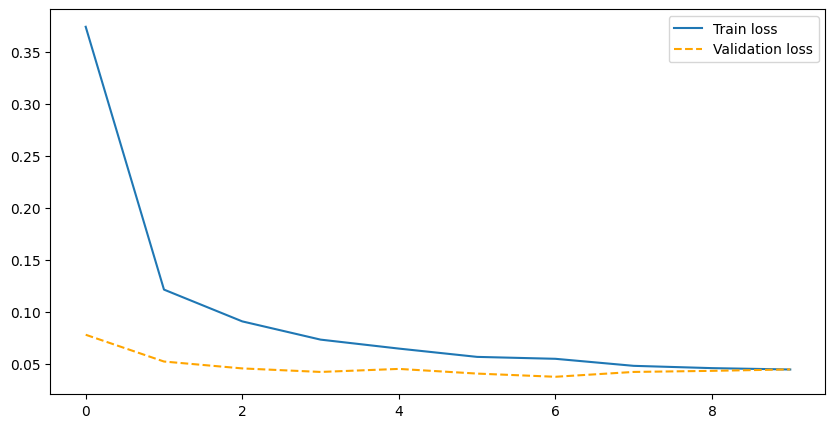

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss', color='orange', linestyle='dashed')
plt.legend()
plt.show()

In [52]:
model.eval()
test_loss = 0
with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.softmax(logits, dim=1).argmax(dim=1)
        accuracy = (preds == y).float().mean()
        loss = criterion(logits, y)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f'Accuracy: {accuracy.item():.4f} | Test Loss: {test_loss:.4f}')

Accuracy: 1.0000 | Test Loss: 0.0376


In [ ]:
# torch.save(model.state_dict(), 'mnist_cnn_v1.pth')
# report_v1 = {
#     'train_losses': train_losses,
#     'val_losses': val_losses,
#     'test_loss': test_loss,
#     'accuracy': accuracy.item() * 100
# }
# 
# report_v1

{'train_losses': [0.27524861656750244,
  0.09957216064756115,
  0.08070871571505753,
  0.06713232163320451,
  0.05557462856173515,
  0.05109979774977546,
  0.04816954579611774,
  0.043692622652451975,
  0.03954629246160039,
  0.03830063499064029],
 'val_losses': [0.06162460487956802,
  0.05110171271643291,
  0.04629940093824795,
  0.0454704784481631,
  0.0430325300709228,
  0.043281000733671436,
  0.040411454940355425,
  0.03799593096562603,
  0.03879781363370057,
  0.03529463293775431],
 'test_loss': 0.0254006774179021,
 'accuracy': 100.0}

Label: 5


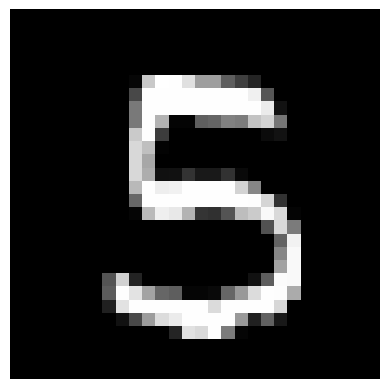

Prediction: 5
Label: 6


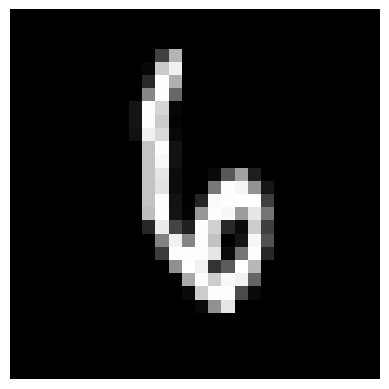

Prediction: 6
Label: 9


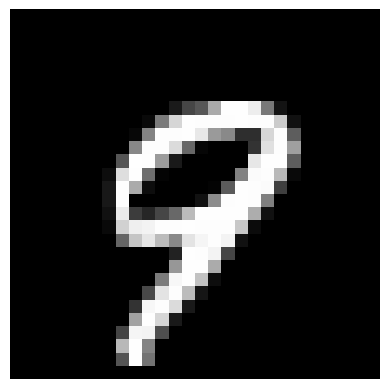

Prediction: 9


In [53]:
import random
model.eval()
for i in random.sample(range(len(test_dset)), 3):
    input_tensor = test_dset[i][0].unsqueeze(0).to(device)  # Add batch dimension
    logit = model(input_tensor)
    pred = torch.softmax(logit, dim=1).argmax(dim=1)
    actual = test_dset[i][1]
    show_image(test_dset[i][0], actual)
    print(f'Prediction: {pred.item()}')